### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Toy dataset (2 Moons)

In [2]:
def get_batch(batch_size):
    data, _ = make_moons(n_samples=batch_size, noise=0.05)
    return torch.tensor(data, dtype=torch.float32)

### Model definition

In [3]:
class ShortcutModel(nn.Module):
    def __init__(self, x_dim=2, hidden=128, depth=4):
        super().__init__()
        # Input: x (2) + t (1) + d (1)
        self.net = nn.Sequential(
            nn.Linear(x_dim + 2, hidden),
            nn.ReLU(),
            *[nn.Sequential(nn.Linear(hidden, hidden), nn.GELU()) for _ in range(depth)],
            nn.Linear(hidden, x_dim)
        )

    def forward(self, x, t, d):
        # x: [B, 2], t: [B, 1], d: [B, 1]
        # Concatenate inputs
        inp = torch.cat([x, t, d], dim=-1)
        return self.net(inp)

### Training loop

In [4]:
def train(model, batch_size=256, steps=10000, lr=1e-3, device='cpu'):
    print("Training Shortcut Model...")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    

    for step in tqdm(range(steps)):
        optimizer.zero_grad()

        # --- Data setup ---
        x1 = get_batch(batch_size).to(device) # Data (t=1)
        x0 = torch.randn_like(x1) # Noise (t=0)
        
        t = torch.rand(batch_size, 1).to(device) # sample random times t ~ U[0, 1]

        xt = (1 - t) * x0 + t * x1 # Linear interpolation to get x_t
        
        v_target_base = x1 - x0 # Ground truth vector field for Flow Matching (d=0)
        

        # --- Regular Flow Matching Loss (Base case: d→0) ---
        d_zero = torch.zeros_like(t)
        v_pred_0 = model(xt, t, d_zero)
        loss_fm = torch.mean((v_pred_0 - v_target_base) ** 2)


        # --- Shortcut Loss (2-step consistency) ---

        # Pick a random step size d
        k = torch.randint(0, 4, (batch_size, 1)).to(device) # Random power k in {0, 1, 2, 3}
        d_val = (1.0 / 16.0) * (2 ** k) # d in {1/16, 1/8, 1/4, 1/2}
        
        t_sc = torch.rand(batch_size, 1).to(device) * (1.0 - 2.0 * d_val) # Sample t in [0, 1-2d] to ensure t+2d <= 1
        
        xt_sc = (1 - t_sc) * x0 + t_sc * x1 # Linear interpolation to get x_t
        
        v_d_1 = model(xt_sc, t_sc, d_val) # Predict velocity for step size d
        
        xt_next = xt_sc + v_d_1 * d_val # Take the first step (Euler)
        
        
        with torch.no_grad(): # Stop gradient on the target for self-distillation stability
            v_d_2 = model(xt_next, t_sc + d_val, d_val) # Take the second step (Euler)
        
        v_target_sc = 0.5 * (v_d_1.detach() + v_d_2) #  Target velocity for the big step (2d): Total displacement is d*v1 + d*v2. The single big step is 2d*v_big. So v_big = (v1 + v2) / 2.
        
        # Loss for shortcut
        v_pred_2d = model(xt_sc, t_sc, 2 * d_val)
        loss_sc = torch.mean((v_pred_2d - v_target_sc) ** 2) 
        
        # --- Total Loss ---
        loss = loss_fm + loss_sc # Total loss
        
        # --- Optimization Step ---
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # --- Loss plot ---
    plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.show()

    return model

### Inference loop

In [5]:
@torch.no_grad()
def sample(model, n_samples=10000, n_steps=1, device='cpu'):
    model.eval()
    x = torch.randn(n_samples, 2).to(device) # Start from noise (t=0)

    # Step size
    d = 1.0 / n_steps
    d_tensor = torch.full((n_samples, 1), d).to(device)
    
    t = 0.0
    for _ in range(n_steps):
        t_tensor = torch.full((n_samples, 1), t).to(device)

        # Predict velocity conditioned on step size d
        v = model(x, t_tensor, d_tensor)
        
        # Euler step
        x = x + v * d
        t += d
        
    return x.cpu().numpy()

### Model training

Training Shortcut Model...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:19<00:00, 358.04it/s]


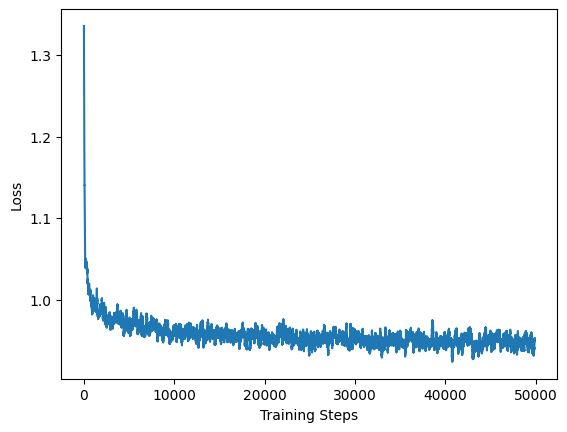

In [6]:
trained_model = train(
    model=ShortcutModel(hidden=128, depth=4),
    batch_size=256,
    steps=50000,
    lr=5e-4,
    device=device
)

### Output visualization

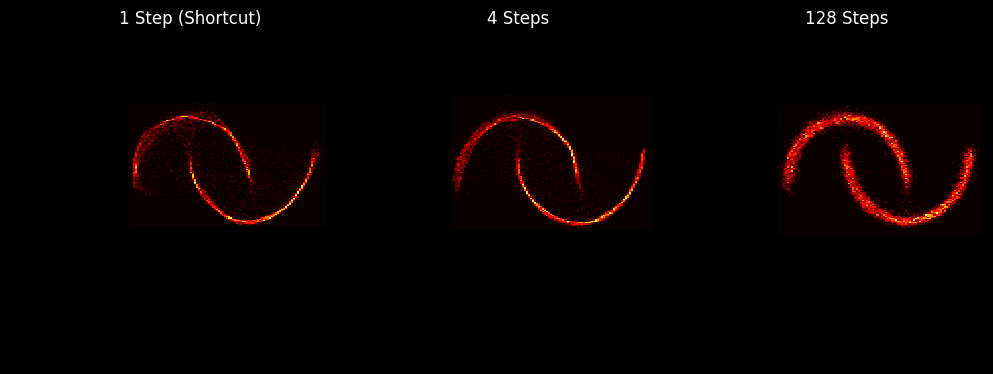

In [7]:
plt.figure(figsize=(12, 4), facecolor='black')
titles = ["1 Step (Shortcut)", "4 Steps", "128 Steps"]
steps_list = [1, 4, 128]

for i, steps in enumerate(steps_list):
    data = sample(trained_model, n_steps=steps, device=device)

    ax = plt.subplot(1, 3, i+1)
    ax.set_facecolor('black')

    plt.hist2d(
        data[:, 0],
        data[:, 1],
        bins=100,
        cmap='hot',
    )

    ax.set_title(titles[i], color='white')
    ax.set_xlim(-2.25, 2.25)
    ax.set_ylim(-2.25, 2.25)

plt.show()